## Baseline XGBoost Model

Tree-based models, specifically gradient boosted decision trees, are generally considered the gold-standard for working with tabular data. While the primary aim of the project is bias mitigation applied to deep-learning it would be dissmisive to not consider model performance against such models for a baseline comparison.

Gradient boosting methods inherit values of input features and then execute countless tree models to halt the loss function. It does this by assimilating weak models, then incrementally and iteratively models weighing data, diligently accompanied by an election of a weak model with the best performance.

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import utilities
import global_variables as gv

from sklearn import metrics
from sklearn.preprocessing import QuantileTransformer, RobustScaler, StandardScaler,MinMaxScaler

### load in data and save DMatrix into a XGBoost binary file

In [21]:
# first retrieve into pandas dataframe
# alternatively:
# df = pd.read_csv('CVD_data.csv')
df = pd.read_csv('data/entire_imputed.csv')
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
df

,1319-0.0,1408-0.0,1329-0.0,1448-0.0,1538-0.0,6142-0.0,2050-0.0,1508-0.0,1339-0.0,30710-0.0,1349-0.0,30750-0.0,1468-0.0,20117-0.0,30740-0.0,1160-0.0,2090-0.0,31-0.0,1488-0.0,30850-0.0,4080-0.0,1369-0.0,21000-0.0,1200-0.0,1289-0.0,30790-0.0,845-0.0,48-0.0,30630-0.0,1299-0.0,1220-0.0,1548-0.0,1528-0.0,23099-0.0,49-0.0,30690-0.0,1389-0.0,2654-0.0,1249-0.0,1309-0.0,1379-0.0,1239-0.0,21003-0.0,30780-0.0,1438-0.0,30870-0.0,1359-0.0,30770-0.0,21001-0.0,1458-0.0,23100-0.0,6138-0.0,1418-0.0,1478-0.0,4079-0.0,30760-0.0,23101-0.0,2100-0.0,1428-0.0,30640-0.0,hypertension,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia,outcome_myocardial_infarction,CVD
0,0.0,1.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0,0.3400,1.0,34.937,3.0,2.0,5.62200,7.0,1.0,0.0,6.00,0.50800,110.0,1.0,1001.0,3.0,6.0,54.4035,20.90,74.0,1.5930,10.0,0.0,2.0,2.00,35.6,102.0,6.47700,1.0,6.0,1.0,2.0,1.0,0.0,54.0,3.88800,10.0,0.97700,2.0,26.33900,24.5790,3.86,25.0,1.0,3.0,1.0,77.0,1.70600,45.2,1.0,0.0,1.21100,0,0,0,0,0,0,0,1,0,1
1,0.0,3.0,2.0,1.0,0.0,1.0,1.0,2.0,2.0,3.9400,4.0,40.900,5.0,2.0,5.05200,9.0,0.0,1.0,2.00,13.08800,166.0,2.0,1001.0,2.0,2.0,15.4000,16.00,120.0,1.3900,2.0,0.0,2.0,2.47,36.5,113.0,5.51200,1.0,7.0,1.0,1.0,2.0,0.0,65.0,3.52000,12.0,2.35800,3.0,10.70100,35.0861,7.00,42.9,3.0,2.0,1.0,91.0,1.17300,74.6,0.0,1.0,1.01900,1,0,1,0,0,0,0,0,1,0
2,0.0,3.0,3.0,2.0,1.0,2.0,1.0,2.0,2.0,0.5500,1.0,40.000,1.0,0.0,5.31000,5.0,0.0,0.0,0.00,0.51500,132.0,1.0,1001.0,3.0,2.0,32.1000,16.00,66.0,2.0050,4.0,0.0,1.0,1.00,29.5,88.0,7.07900,1.0,7.0,3.0,4.0,2.0,0.0,69.0,4.22700,8.0,0.65500,2.0,10.69300,19.3835,7.00,15.2,3.0,2.0,1.0,67.0,2.49000,36.3,0.0,1.0,1.09700,0,0,0,0,0,0,0,0,0,0
3,3.0,3.0,3.0,3.0,0.0,2.0,1.0,2.0,2.0,0.4500,2.0,37.300,4.0,2.0,4.44900,7.0,0.0,1.0,5.00,4.67500,178.0,2.0,1001.0,1.0,3.0,43.5620,18.00,110.0,1.4740,2.0,0.0,1.0,2.00,28.5,117.0,5.02800,0.0,7.0,1.0,1.0,2.0,1.0,66.0,3.04100,10.0,3.10800,2.0,25.31700,35.1281,7.00,31.7,3.0,2.0,1.0,84.0,1.16900,79.6,0.0,3.0,0.92300,0,0,0,0,0,0,0,0,0,0
4,0.0,3.0,2.0,1.0,0.0,5.0,2.0,2.0,2.0,0.7500,2.0,32.200,1.0,2.0,4.61600,6.0,0.0,1.0,3.04,20.16200,178.0,1.0,1001.0,3.0,1.0,71.1100,22.38,94.0,2.1490,1.0,0.0,2.0,2.00,24.8,100.0,7.95800,1.0,7.0,2.0,1.0,1.0,0.0,48.0,4.98300,8.0,1.17300,1.0,26.52300,25.8866,1.00,20.1,1.0,2.0,1.0,88.0,2.05300,61.0,0.0,3.0,1.44300,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502476,0.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.4500,3.0,28.000,1.0,2.0,4.50900,7.0,0.0,1.0,0.00,17.13700,147.0,1.0,1001.0,2.0,2.0,5.3000,16.00,110.0,1.3450,0.0,0.0,2.0,0.00,27.0,113.0,5.75400,1.0,4.0,1.0,2.0,1.0,2.0,63.0,3.84300,4.0,3.82000,2.0,20.77700,30.6094,7.00,29.8,3.0,1.0,3.0,91.0,1.02600,80.7,0.0,3.0,1.13700,0,0,0,0,0,0,0,0,0,0
502477,0.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,2.7500,1.0,33.200,1.0,1.0,5.67300,6.0,1.0,0.0,0.00,0.72500,148.0,2.0,1001.0,3.0,4.0,5.0900,16.00,102.0,1.3650,3.0,0.0,3.0,3.00,46.3,110.0,4.66400,2.0,7.0,1.0,6.0,2.0,0.0,64.0,2.86300,4.0,2.13400,3.0,23.64700,31.4652,7.00,38.7,3.0,3.0,2.0,73.0,1.15900,44.9,0.0,1.0,0.89800,1,0,1,0,0,0,0,0,0,0
502478,2.0,1.0,1.0,2.0,2.0,1.0,4.0,2.0,2.0,0.8500,3.0,31.500,3.0,2.0,4.85100,7.0,1.0,1.0,20.00,12.04000,133.0,2.0,1001.0,2.0,2.0,37.5575,22.08,99.0,1.2410,2.0,1.0,3.0,1.00,25.7,98.0,5.18400,1.0,7.0,1.0,2.0,2.0,0.0,43.0,3.35800,20.0,2.54700,3.0,22.50700,28.6196,10.00,23.6,1.0,1.0,1.0,81.0,1.04300,68.1,1.0,1.0,0.98500,1,0,1,0,0,1,0,1,1,1
502479,3.0,3.0,1.0,3.0,0.0,1.0,1.0,2.0,2.0,3.5700,2.0,45.700,1.0,2.0,5.50600,6.0,0.0,0.0,4.00,1.18648,138.0,1.0,1001.0,3.0,4.0,27.4800,19.64,86.0,1.6690,2.0,0.0,2.0,2.00,41.3,111.0,6.82700,1.0,7.0,4.0,1.0,1.0,0.0,56.0,4.20000,12.0,2.09000,3.0,30.49800,27.3702,7.00,3

In [18]:
# # switch 
# # get a list of the columns
# col_list = list(df)
# # use this handy way to swap the elements
# col_list[-10], col_list[-2], col_list[-1]  = col_list[-1], col_list[-10], col_list[-2]
# # assign back, the order will now be swapped
# df=df.loc[:,col_list]

# df.to_csv('data/entire_imputed.csv')

### preprocess input features

In [11]:
X_train, X_test, y_train, y_test = utilities.process_features(df, 'CVD', StandardScaler(), one_hot=False, val=False)
X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

In [8]:
X_train.rename(columns=gv.input_mapping, inplace=True)
# X_val.rename(columns=gv.input_mapping, inplace=True)
X_test.rename(columns=gv.input_mapping, inplace=True)

NameError: name 'X_val' is not defined

In [12]:
X_train

,1319-0.0,1408-0.0,1329-0.0,1448-0.0,1538-0.0,6142-0.0,2050-0.0,1508-0.0,1339-0.0,30710-0.0,1349-0.0,30750-0.0,1468-0.0,20117-0.0,30740-0.0,1160-0.0,2090-0.0,31-0.0,1488-0.0,30850-0.0,4080-0.0,1369-0.0,21000-0.0,1200-0.0,1289-0.0,30790-0.0,845-0.0,48-0.0,30630-0.0,1299-0.0,1220-0.0,1548-0.0,1528-0.0,23099-0.0,49-0.0,30690-0.0,1389-0.0,2654-0.0,1249-0.0,1309-0.0,1379-0.0,1239-0.0,21003-0.0,30780-0.0,1438-0.0,30870-0.0,1359-0.0,30770-0.0,21001-0.0,1458-0.0,23100-0.0,6138-0.0,1418-0.0,1478-0.0,4079-0.0,30760-0.0,23101-0.0,2100-0.0,1428-0.0,30640-0.0,outcome_myocardial_infarction
0,-0.510582,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,-0.413853,1.0,0.056018,5.0,2.0,-0.559081,0.765203,1.0,0.0,-1.239244,-0.822237,-0.503452,1.0,1001.0,3.0,-0.409003,-0.941094,-0.392208,-0.098445,-0.070936,0.343362,0.0,3.0,-1.314055,0.850431,-0.585172,0.251452,1.0,7.0,1.0,-0.807512,1.0,0.0,-0.436369,0.372748,-0.991989,-0.709330,2.0,-0.702292,-0.040858,-1.737645,0.167933,3.0,2.0,2.0,0.272506,0.107010,-1.013950,0.0,1.0,0.673023,0
1,-0.510582,3.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,-0.508831,1.0,-0.063877,2.0,2.0,-0.809147,-0.138180,0.0,1.0,-1.239244,1.173511,0.434703,1.0,1001.0,3.0,0.114927,-0.959715,1.011147,-1.063226,-0.023005,-0.125576,1.0,1.0,0.058993,-2.104533,-0.693264,-1.105439,1.0,6.0,4.0,-0.178187,1.0,0.0,0.922648,-1.051164,0.900124,-0.983163,2.0,-0.957674,-1.060355,0.882695,-1.614841,1.0,2.0,1.0,0.080040,-0.057784,0.652229,0.0,3.0,-1.214039,0
2,0.059161,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,0.286608,1.0,0.610528,1.0,2.0,0.280068,0.765203,0.0,1.0,-1.239244,0.715661,0.121985,1.0,1003.0,2.0,0.114927,-0.074183,-0.756715,0.495267,0.065484,-0.594514,1.0,2.0,-0.398689,-0.096081,-0.044712,0.775746,2.0,7.0,1.0,-0.178187,1.0,0.0,-1.424745,0.702072,-1.110246,0.012594,1.0,-0.442928,0.098165,0.882695,-0.132651,3.0,3.0,2.0,0.753669,-0.302318,0.010056,0.0,0.0,0.694516,0
3,0.059161,3.0,2.0,1.0,0.0,2.0,1.0,2.0,2.0,-0.238144,2.0,-0.198758,5.0,2.0,-0.032935,0.765203,1.0,0.0,-0.534766,-0.763867,2.623733,2.0,1001.0,1.0,0.638857,2.597888,0.336808,-0.543728,0.670160,-0.125576,0.0,2.0,-0.398689,1.369859,0.063380,0.153763,2.0,6.0,1.0,-0.178187,2.0,0.0,0.799101,-0.109392,-0.637218,-0.549013,2.0,-0.135058,0.151746,0.882695,0.665451,3.0,2.0,2.0,0.561204,0.891113,-1.074696,1.0,3.0,-0.044834,1
4,0.059161,1.0,2.0,3.0,0.0,1.0,1.0,2.0,2.0,-0.394858,1.0,-0.048890,3.0,2.0,-0.285292,-0.138180,1.0,0.0,0.874190,-0.876902,-0.555572,2.0,1001.0,2.0,1.162787,-0.392696,-0.756715,-2.102221,0.691397,-0.125576,0.0,2.0,-0.398689,-0.246138,-1.882278,-0.249540,1.0,7.0,4.0,-0.178187,1.0,0.0,0.181366,-0.438716,1.018381,-0.800939,3.0,-0.880933,-0.652719,-0.988976,-0.992943,3.0,3.0,3.0,-0.401123,0.817115,-1.439173,0.0,3.0,-0.474689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73627,-0.510582,2.0,2.0,1.0,0.0,2.0,2.0,2.0,2.0,0.623778,2.0,-0.213744,3.0,2.0,-0.643835,-1.041563,1.0,0.0,0.521951,-0.869344,-0.711931,1.0,1001.0,3.0,-0.932932,0.132891,-0.027700,-0.617942,1.164223,-0.552310,0.0,2.0,0.058993,1.208259,-0.368988,-0.665390,1.0,7.0,1.0,-1.436836,1.0,0.0,0.552007,-0.862809,-0.637218,-0.775050,3.0,-0.858127,-0.477565,0.508361,0.333773,3.0,1.0,2.0,-1.170985,0.867191,-1.256934,0.0,1.0,-1.072187,0
73628,-0.510582,2.0,1.0,4.0,0.0,4.0,1.0,2.0,2.0,0.103775,2.0,-0.258705,5.0,2.0,-0.976138,-0.138180,0.0,0.0,-0.182527,-0.885468,-0.242853,2.0,1001.0,3.0,0.114927,-0.826573,-1.121223,-1.434295,-0.399083,-0.125576,1.0,1.0,-1.314055,0.250204,-0.801357,0.171687,1.0,7.0,4.0,-0.807512,1.0,0.0,0.057819,-0.030023,-0.045932,-0.089969,1.0,-1.827348,-0.461135,-1.737645,-0.671629,3.0,5.0,1.0,-0.593589,-0.166761,-1.482563,0.0,0.0,-0.315643,0
73629,2.338129,1.0,1.0,1.0,0.0,2.0,1.0,3.0,1.0,-0.482712,1.0,-0.423559,4.0,2.0,-0.398627,0.765203,1.0,1.0,0.521951,2.673866,-1.181009,1.0,1001.0,3.0,-0.409003,-0.926197,-1.121223,-0.395300,-0.278775,-1.0634

### build & save model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     91183
           1       0.18      0.68      0.29      9314

    accuracy                           0.69    100497
   macro avg       0.57      0.68      0

Text(0.5, 1.0, 'CVD')

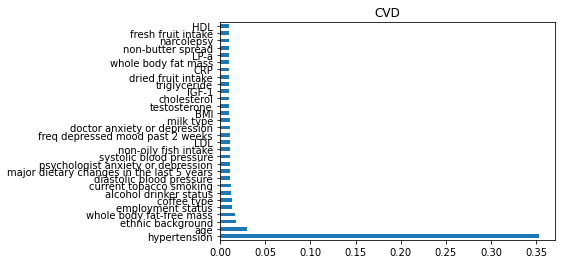

In [24]:
# feature_importance

X_train, X_test, y_train, y_test = utilities.process_features(df, 'CVD', StandardScaler(), one_hot=False, val=False)
X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

X_train.rename(columns=gv.input_mapping, inplace=True)
X_test.rename(columns=gv.input_mapping, inplace=True)

clf=xgb.XGBClassifier(max_depth=10, 
                      learning_rate=0.1, 
                      n_estimators=800,
                      objective='binary:logistic', 
                      booster='gbtree')

#Printing all the parameters of XGBoost
print(clf)

#Creating the model on Training Data
XGB=clf.fit(X_train,y_train)
prediction=XGB.predict(X_test)

#Measuring accuracy on Testing Data
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))


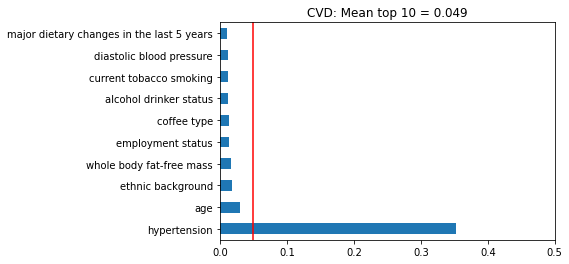

In [38]:
#Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(XGB.feature_importances_, index=X_train.columns.to_list())
feature_importances.nlargest(10).plot(kind='barh')
av=round(feature_importances.nlargest(10).mean(),3)
plt.title('CVD: Mean top 10 = ' + str(av))
plt.xlim(0,0.5)
plt.vlines(av, -20, 100, color='red')
plt.savefig('charts/models/XGBoost/feat_CVD.png', bbox_inches='tight')


In [29]:
# accuracy
p1=0.63
p2=0.56
p3=0.65
p4=0.61
p5=0.64
p6=0.56
p7=0.58
p8=0.59

(p1+p2+p3+p4+p5+p6+p7+p8)/8

0.6024999999999999

In [30]:
# precision
p1=0.71
p2=0.93
p3=0.66
p4=0.77
p5=0.87
p6=0.94
p7=0.85
p8=0.59
(p1+p2+p3+p4+p5+p6+p7+p8)/8

0.79

In [31]:
# recall
p1=0.63
p2=0.56
p3=0.65
p4=0.61
p5=0.64
p6=0.56
p7=0.58
p8=0.59
(p1+p2+p3+p4+p5+p6+p7+p8)/8

0.6024999999999999

In [32]:
# f1
p1=0.65
p2=0.69
p3=0.65
p4=0.66
p5=0.72
p6=0.69
p7=0.67
p8=0.59
(p1+p2+p3+p4+p5+p6+p7+p8)/8

0.665

In [28]:
prediction=XGB.predict(X_test)
prediction

NotFittedError: need to call fit or load_model beforehand

## Results from basic XGBoost
***

Initial results from the XGBoost Model indicate the most promising results for the following subset of outcomes: 

<ol>
    <li>Ischemic Heart Disease</li>
    <li>Peripheral Vascular Disease</li>
    <li>Myocardial Infarction</li>
    <li>Heart Failure</li>
</ol>

Overall performance was determined by the prioritization of Recall for the prioritization of false negative reduction. Because we are working in a medical domain space, the critical circumstance is to identify positive individuals. Recall as the primary metric is secondarily priortized because of the large skew toward negative cases in the dataset regarding each outcome


#### full outcome set:

<ul>
    <li>Myocardial Infarction</li>
    <li>Cardiomyopathies</li>
    <li>Ischemic Heart Disease</li>
    <li> Heart Failure</li>
    <li>Peripheral Vascular Disease</li>
    <li>Cardiac Arrest</li>
    <li>Cerebral Infarction</li>
    <li>Arrhythmia</li>
</ul>

['outcome_myocardial_infarction','outcome_cardiomyopathies','outcome_ischemic_heart_disease','outcome_heart_failure','outcome_peripheral_vascular_disease','outcome_cardiac_arrest','outcome_cerebral_infarction','outcome_arrhythmia']


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = utilities.process_features(df, gv.outcomes[-1], StandardScaler(), one_hot=False, val=True)
X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

In [9]:
X_train.rename(columns=gv.input_mapping, inplace=True)
X_val.rename(columns=gv.input_mapping, inplace=True)
X_test.rename(columns=gv.input_mapping, inplace=True)

In [ ]:
from xgboost import XGBClassifier

n_estimators = 1000

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.01,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="binary:logistic",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=40,
            verbose=20)

              precision    recall  f1-score   support

           0       0.58      0.61      0.59      8094
           1       0.64      0.61      0.63      9297

    accuracy                           0.61     17391
   macro avg       0.61      0.61      0.61     17391
weighted avg       0.61      0.61      0.61     17391

[[4958 3136]
 [3637 5660]]


Text(0.5, 1.0, 'Arrhythmia')

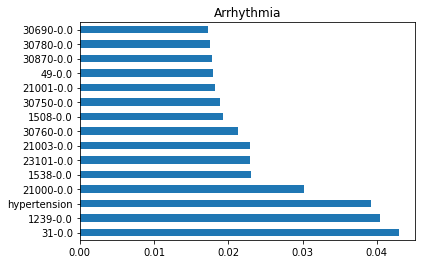

In [15]:
prediction=clf_xgb.predict(X_test)

#Measuring accuracy on Testing Data
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

#Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(clf_xgb.feature_importances_, index=X_train.columns.to_list())
feature_importances.nlargest(15).plot(kind='barh')
plt.title('Arrhythmia')